In [169]:
# transform a GESAMT output to a pairwise aln

import json
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

gesamtfile = '/home/hildilab/projects/agpcr_nom/map_lat-1/indexing_sdb.out'



data = open(gesamtfile).readlines()

tline = [l for l in data if l.strip().startswith("FIXED")]
template = tline[0].split("pdbs/")[1].split("_")[0]
if "sdb" in gesamtfile: 
	sd = "sdb"
else:  
	sd = "sda"
	
print("FOUND FILE TEMPLATE:", template, "WITH SUBDOMAIN", sd)

pw_lines = [l[1:] for l in data if l.startswith("|")]

data_arr = np.empty(shape=(5,len(pw_lines)-2), dtype=object)
# 0 		1 		2		3		4
# a_resid	a_idx	dist	b_resid	b_idx

for i,line in enumerate(pw_lines[2:]):
	data_arr[0,i] = line[5:9].strip()
	try:
		data_arr[1,i] = int(line[9:13])
	except:
		data_arr[1,i] = None
	try: 
		data_arr[2,i] = float(line[18:22])
	except:
		data_arr[2,i] = 5.0
	data_arr[3,i] = line[32:36].strip()
	try:
		data_arr[4,i] = int(line[36:40])
	except:
		data_arr[4,i] = None
#print(data_arr)

oneletter = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M', '': ' '}

font = {'family': 'FreeMono',
        'color':  'black',
        'weight': 'normal',
        'size': 30,
        }
cfont = {'family': 'FreeMono',
        'color':  'black',
        'weight': 'bold',
        'size': 30,
        }
lfont = {'family': 'FreeSerif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }
tdata = SimpleNamespace(**json.load(open('template_data.json','r')))
if sd == "sdb":
	sd_centers = tdata.sdb_centers[template]
else:
	sd_centers = tdata.sda_centers[template]
sd_extents = tdata.element_extents[template]

spec = cm.get_cmap('jet',128)
c_spec = np.vstack((spec(np.linspace(0,1,120)),(1,1,1,1)))
cm_spec = ListedColormap(c_spec, name='newSpec')

print("AVAILABLE KEYS:\n", sd_centers.keys())

FOUND FILE TEMPLATE: E5b WITH SUBDOMAIN sdb
AVAILABLE KEYS:
 dict_keys(['S1', 'S2', 'S3', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14'])


{'H1.50': 246, 'H2.50': 266, 'H3.50': 278, 'H4.50': 311, 'H5.50': 324, 'H6.50': 344, 'S1.50': 363, 'S2.50': 370, 'S3.50': 388, 'S5.50': 404, 'S6.50': 424, 'S7.50': 453, 'S8.50': 457, 'S9.50': 478, 'S10.50': 500, 'S11.50': 507, 'S12.50': 512, 'S13.50': 526, 'S14.50': 535, 'GPS': 529}
[512, 518] 512
170 176 170 175
170 176
['C', 'S', 'P', 'Q', 'H', 'S', 'N'] ['C', 'K', 'L', 'S', 'Y', 'H', 'N']


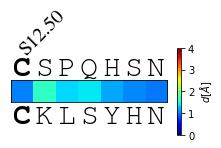

In [170]:
el = 'S12'

target_gain = np.load("../map_lat-1/G5EDW2.pkl", allow_pickle=True)

#el_intervals, el_centers, res_labels, unindexed_el, params
indexing = np.load("../map_lat-1/indexing.pkl", allow_pickle=True)
print(indexing[1])

target_element = indexing[0][el]
target_center = indexing[1][f"{el}.50"]
print(target_element, target_center)

el_ex = sd_extents[el]
center = sd_centers[el]

start, end = el_ex[0], el_ex[1]

tar_left_idx = np.where(data_arr[4:,:]==target_element[0])[1][0]
tar_right_idx = np.where(data_arr[4:,:]==target_element[1])[1][0]



tem_left_idx = np.where(data_arr[1:,:]==start)[1][0]
tem_right_idx = np.where(data_arr[1:,:]==end)[1][0]
center_idx = np.where(data_arr[1:,:]==center)[1][0]

print(tar_left_idx, tar_right_idx, tem_left_idx, tem_right_idx)

left_idx = min([tar_left_idx, tem_left_idx])
right_idx = max([tar_right_idx, tem_right_idx])

print(left_idx, right_idx)
slic = data_arr[:,left_idx:right_idx+1]
dist = [float(v) for v in slic[2,:]]

fig = plt.figure(facecolor='w', figsize=[(end-start)/2+1,2])
plt.imshow([dist], cmap = cm_spec, vmin=0, vmax=4)
cbar = plt.colorbar(shrink=0.8)
cbar.set_label("$d [\AA]$")
plt.xticks([])
plt.yticks([])

topstr = [oneletter[res] for res in slic[0]]
botstr = [oneletter[res] for res in slic[3]]
print(topstr,botstr)
for i,aa in enumerate(topstr):
    if i != center-start:
        plt.text(i,-1, aa, fontdict=font, horizontalalignment='center', verticalalignment='center')
    else:
        plt.text(i,-1, aa, fontdict=cfont, horizontalalignment='center', verticalalignment='center')
        plt.text(i-0.2,-1.5, f"{el}.50", rotation=45, verticalalignment='bottom', fontdict=lfont)
for j,aa in enumerate(botstr):
    if j != center-start:
        plt.text(j,1.15, aa, fontdict=font, horizontalalignment='center', verticalalignment='center')
    else:   
        plt.text(j,1.15, aa, fontdict=cfont, horizontalalignment='center', verticalalignment='center')

plt.savefig(f"../fig/aln_{el}_{template}.svg",bbox_inches='tight')